# RUL and SOH Estimator

## Data Description:

    A set of four Li-ion batteries (# 45 - 48) were run through 3 different operational profiles (charge, discharge and impedance) at an ambient temperature of 4 deg C. 
    Charging was carried out in a constant current (CC) mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. 
    "Fixed load current level of 1A" was used and the discharge runs were stopped at 2V, 2.2V, 2.5V and 2.7V for batteries 45, 46, 47 and 48 respectively.
    Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep from 0.1Hz to 5kHz. The experiments were carried out until the capacity had reduced to 1.4Ahr (30% fade). 
    Note that there are several discharge runs where the capacity was very low. Reasons for this have not been fully analyzed.

### Files:
    B0045.mat	Data for Battery #45
    B0046.mat	Data for Battery #46
    B0047.mat	Data for Battery #47
    B0048.mat	Data for Battery #48

## Data Structure:
    cycle-	top level structure array containing the charge, discharge and impedance operations
	type: 	operation  type, can be charge, discharge or impedance
	ambient_temperature:	ambient temperature (degree C)
	time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	data:	data structure containing the measurements
#### for charge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at charger (Amps)
		Voltage_charge:		Voltage measured at charger (Volts)
		Time:			Time vector for the cycle (secs)
#### for discharge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at load (Amps)
		Voltage_charge:		Voltage measured at load (Volts)
		Time:			Time vector for the cycle (secs)
		Capacity:		Battery capacity (Ahr) for discharge till 2.7V
#### for impedance the fields are:
		Sense_current:		Current in sense branch (Amps)
		Battery_current:	Current in battery branch (Amps)
		Current_ratio:		Ratio of the above currents
		Battery_impedance:	Battery impedance (Ohms) computed from raw data
		Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms)
		Re:			Estimated electrolyte resistance (Ohms)
		Rct:			Estimated charge transfer resistance (Ohms)
##### link: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

##### Data Export

In [1]:
import scipy.io
import pandas
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
sns.set()
#print(mat)

In [2]:
bat1=scipy.io.loadmat('BatteryAgingARC_45_46_47_48/B0045.mat')["B0045"][0][0][0][0]#Battery B0045
bat2=scipy.io.loadmat('BatteryAgingARC_45_46_47_48/B0046.mat')["B0046"][0][0][0][0]#Battery B0046
bat3=scipy.io.loadmat('BatteryAgingARC_45_46_47_48/B0047.mat')["B0047"][0][0][0][0]#Battery B0047
bat4=scipy.io.loadmat('BatteryAgingARC_45_46_47_48/B0048.mat')["B0048"][0][0][0][0]#Battery B0048
batteries=np.concatenate((bat1,bat2,bat3,bat4))
#m.shape



##### Getting DataFrame 

In [3]:
## Maximum voltage drop

def maxDiff(arr): 
    if(len(arr) < 2):
        return -1; # error condition: throw exception?

    maxdiff = float('-inf')
    for i in range(1,len(arr)):
        diff=abs(arr[i]-arr[i-1])
        if(diff>maxdiff):
            maxdiff=diff

    return maxdiff;


In [4]:
def build(mess):
    discharge, charge, impedance = {}, {}, {}

    for i, element in enumerate(mess):

        step = element[0][0]

        if step == 'discharge':
            discharge[str(i)] = {}
            discharge[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)
            discharge[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")
            data = element[3]
            #discharge[str(i)]["time_min"] = (data[0][0][5][0]/60).tolist()
            discharge[str(i)]["time_sec"] = (data[0][0][5][0]).tolist()
            discharge[str(i)]["time_taken"] = discharge[str(i)]["time_sec"][len(discharge[str(i)]["time_sec"])-1]-discharge[str(i)]["time_sec"][0]
            discharge[str(i)]["temp_battery"] = data[0][0][2][0].tolist()
            discharge[str(i)]["voltage_load"] = data[0][0][4][0].tolist()
            discharge[str(i)]["voltage_battery"] = data[0][0][0][0].tolist()
            discharge[str(i)]["current_battery"] = data[0][0][1][0].tolist()
            
            discharge[str(i)]["current_load"] = data[0][0][3][0].tolist()
            
            discharge[str(i)]["capacity"] = data[0][0][6][0][0]
            discharge[str(i)]["max_voltage_drop"]=maxDiff(data[0][0][4][0].tolist())
            #print(len(discharge[str(i)]['temp_battery'])-1)
            discharge[str(i)]["deltaV"] = discharge[str(i)]["voltage_battery"][0]-discharge[str(i)]["voltage_battery"][1]
            discharge[str(i)]["auc"]= auc(data[0][0][5][0].tolist(),data[0][0][0][0].tolist())
    

        if step == 'charge':
            charge[str(i)] = {}
            charge[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)        

            charge[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")

            data = element[3]

            charge[str(i)]["voltage_battery"] = data[0][0][0][0].tolist()
            charge[str(i)]["current_battery"] = data[0][0][1][0].tolist()
            charge[str(i)]["temp_battery"] = data[0][0][2][0].tolist()
            charge[str(i)]["current_load"] = data[0][0][3][0].tolist()
            charge[str(i)]["voltage_load"] = data[0][0][4][0].tolist()
            #charge[str(i)]["time_min"] = (data[0][0][5][0]/60).tolist()
            charge[str(i)]["time_sec"] = (data[0][0][5][0]).tolist()
            charge[str(i)]["time_taken"] = charge[str(i)]["time_sec"][len(charge[str(i)]["time_sec"])-1]-charge[str(i)]["time_sec"][0]

        if step == 'impedance':
            impedance[str(i)] = {}
            impedance[str(i)]["amb_temp"] = str(element[1][0][0])
            year = int(element[2][0][0])
            month = int(element[2][0][1])
            day = int(element[2][0][2])
            hour = int(element[2][0][3])
            minute = int(element[2][0][4])
            second = int(element[2][0][5])
            millisecond = int((second % 1)*1000)
            date_time = datetime.datetime(year, month, day, hour, minute, second, millisecond)        

            impedance[str(i)]["date_time"] = date_time.strftime("%d %b %Y, %H:%M:%S")

            data = element[3]

            impedance[str(i)]["sense_current"] = {}
            impedance[str(i)]["battery_current"] = {}
            impedance[str(i)]["current_ratio"] = {}
            impedance[str(i)]["battery_impedance"] = {}
            impedance[str(i)]["rectified_impedance"] = {}

            impedance[str(i)]["sense_current"]["real"] = np.real(data[0][0][0][0]).tolist()
            impedance[str(i)]["sense_current"]["imag"] = np.imag(data[0][0][0][0]).tolist()

            impedance[str(i)]["battery_current"]["real"] = np.real(data[0][0][1][0]).tolist()
            impedance[str(i)]["battery_current"]["imag"] = np.imag(data[0][0][1][0]).tolist()

            impedance[str(i)]["current_ratio"]["real"] = np.real(data[0][0][2][0]).tolist()
            impedance[str(i)]["current_ratio"]["imag"] = np.imag(data[0][0][2][0]).tolist()

            impedance[str(i)]["battery_impedance"]["real"] = np.real(data[0][0][3]).tolist()
            impedance[str(i)]["battery_impedance"]["imag"] = np.imag(data[0][0][3]).tolist()

            impedance[str(i)]["rectified_impedance"]["real"] = np.real(data[0][0][4]).tolist()
            impedance[str(i)]["rectified_impedance"]["imag"] = np.imag(data[0][0][4]).tolist()

            impedance[str(i)]["re"] = float(data[0][0][5][0][0])
            impedance[str(i)]["rct"] = float(data[0][0][6][0][0])
            
    return discharge, charge, impedance

### Charge and discharge
    During discharge, lithium ions (Li+) carry the current within the battery from the negative to the positive electrode, through the non-aqueous electrolyte and separator diaphragm.
    During charging, an external electrical power source (the charging circuit) applies an over-voltage (a higher voltage than the battery produces, of the same polarity), forcing a charging current to flow within the battery from the positive to the negative electrode, i.e. in the reverse direction of a discharge current under normal conditions. The lithium ions then migrate from the positive to the negative electrode, where they become embedded in the porous electrode material in a process known as intercalation.

In [5]:
discharge, charge, impedance=build(batteries)#building dataset using build function
discharge = pd.DataFrame(discharge).T#Transpose to change row to columns and Vice versa
impedance = pd.DataFrame(impedance).T#Transpose to change row to columns and Vice versa
charge = pd.DataFrame(charge).T#Transpose to change row to columns and Vice versa



#Assign the cycles to each battery


    Battery cycles are a shorthand used by manufacturers to estimate battery life. A battery cycle represents what happens when the battery is fully charged and then used until it empties – that's one cycle.

In [6]:
index=[i for i in range(1,73,1)]
index=index+index+index+index
discharge['cycle']=index
discharge.set_index(['cycle'])

,amb_temp,date_time,time_sec,time_taken,temp_battery,voltage_load,voltage_battery,current_battery,current_load,capacity,max_voltage_drop,deltaV,auc
cycle,,,,,,,,,,,,,
1,4,"21 Jul 2010, 15:00:35","[0.0, 9.36, 23.281, 36.406, 49.625, 62.813, 75...",6436.141,"[6.546128313360122, 6.566538966413903, 6.60525...","[0.0, 4.219, 3.487, 3.455, 3.429, 3.413, 3.4, ...","[4.202937200343293, 4.203467627142882, 3.95733...","[-0.0018552703653270512, -0.001992478957768281...","[0.0004, 0.0004, 0.998, 0.998, 0.998, 0.998, 0...",1.081979,4.219,-0.00053,21562.16542
2,4,"21 Jul 2010, 21:02:56","[0.0, 9.297000000000004, 23.265, 36.437, 49.60...",5650.265,"[5.661731233736432, 5.6775148455034135, 5.7212...","[0.0, 4.182, 3.459, 3.431, 3.407, 3.39, 3.376,...","[4.1669008679698605, 4.16699885717682, 3.94611...","[-0.001150394384183579, -0.0017061563816917844...","[0.0004, 0.0004, 0.998, 0.998, 0.998, 0.998, 0...",0.927952,4.182,-0.000098,18888.827828
3,4,"22 Jul 2010, 01:40:06","[0.0, 9.327999999999996, 23.312999999999995, 3...",5590.907,"[6.421987720230596, 6.437000612110659, 6.48109...","[0.0, 4.203, 3.481, 3.45, 3.426, 3.409, 3.395,...","[4.187652780308948, 4.187894400053388, 3.97311...","[-0.0030030158764916817, -0.001890347298576509...","[0.0004, 0.0006, 0.998, 0.998, 0.998, 0.9978, ...",0.885194,4.203,-0.000242,18764.771362
4,4,"22 Jul 2010, 06:16:21","[0.0, 9.36, 23.375, 36.672, 49.843999999999994...",5543.61,"[4.777824751111958, 4.800656970715685, 4.85122...","[0.0, 4.203, 3.463, 3.438, 3.411, 3.391, 3.379...","[4.188401226248918, 4.187855957323515, 3.96125...","[-0.001242202864217661, -0.0003409131250554628...","[0.0004, 0.0004, 0.998, 0.998, 0.998, 0.998, 0...",0.858101,4.203,0.000545,18615.011292
5,4,"22 Jul 2010, 10:51:48","[0.0, 9.375, 23.421, 36.703, 49.968, 63.187, 7...",5499.046,"[5.04727429257204, 5.079921304163988, 5.109768...","[0.0, 4.203, 3.472, 3.441, 3.416, 3.395, 3.381...","[4.188303916193977, 4.187851218652247, 3.96142...","[-0.001892744902961866, -0.0009481918094807882...","[0.0004, 0.0004, 0.998, 0.998, 0.998, 0.998, 0...",0.840935,4.203,0.000453,18506.961945
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,4,"16 Aug 2010, 16:33:48","[0.0, 9.422, 25.375000000000004, 40.532, 55.71...",4663.907,"[6.3964728651306295, 6.422202310239693, 6.4550...","[0.0, 4.167, 3.411, 3.389, 3.371, 3.353, 3.337...","[4.151836918495948, 4.151970239591361, 3.94971...","[0.001690124978097079, -0.0006515652189745722,...","[0.0006, 0.0004, 0.999, 0.999, 0.999, 0.999, 0...",1.269122,4.167,-0.000133,15887.539078
69,4,"16 Aug 2010, 20:54:56","[0.0, 9.437999999999999, 25.343999999999998, 4...",4581.328,"[5.2083237131583076, 5.0361782125586165, 4.914...","[0.0, 4.186, 3.429, 3.407, 3.388, 3.367, 3.352...","[4.170962379739071, 4.170475146377669, 3.96546...","[-0.007257871015229779, 0.001349801462907186, ...","[0.0006, 0.0006, 0.999, 0.999, 0.999, 0.999, 0...",1.255514,4.186,0.000487,15624.458277
70,4,"17 Aug 2010, 01:14:42","[0.0, 9.343, 25.297, 40.422, 55.578, 70.672, 8...",4553.031,"[6.135373803303162, 5.695653545756759, 5.48054...","[0.0, 4.186, 3.432, 3.412, 3.39, 3.371, 3.356,...","[4.171135033653532, 4.170619964813752, 3.96793...","[-0.0004713698150211577, -0.000702011286643080...","[0.0004, 0.0004, 0.999, 0.999, 0.999, 0.999, 0...",1.251988,4.186,0.000515,15498.583011


#### Battery Capacity (faded for 30% from initial) 
    Battery capacity (AH) is defined as a product of the current that is drawn from the battery while the    battery is able to supply the load until its voltage is dropped to lower than a certain value for each cell.


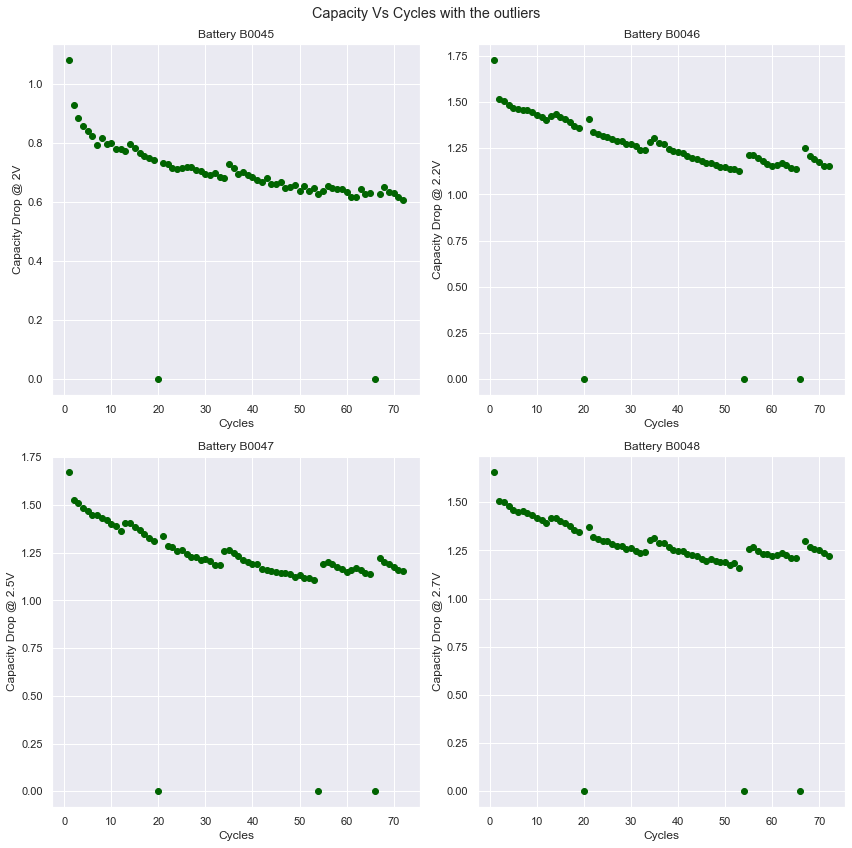

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Capacity Vs Cycles with the outliers')

axs[0,0].scatter(discharge['cycle'][:72],discharge['capacity'][:72],color='Darkgreen')
axs[0,0].set_title("Battery B0045")
axs[0,0].set_xlabel("Cycles")
axs[0,0].set_ylabel("Capacity Drop @ 2V")

axs[0,1].scatter(discharge['cycle'][72:144],discharge['capacity'][72:144],color='Darkgreen')
axs[0,1].set_title("Battery B0046")
axs[0,1].set_xlabel("Cycles")
axs[0,1].set_ylabel("Capacity Drop @ 2.2V")

axs[1,0].scatter(discharge['cycle'][144:216],discharge['capacity'][144:216],color='Darkgreen')
axs[1,0].set_title("Battery B0047")
axs[1,0].set_xlabel("Cycles")
axs[1,0].set_ylabel("Capacity Drop @ 2.5V")

axs[1,1].scatter(discharge['cycle'][216:],discharge['capacity'][216:],color='Darkgreen')
axs[1,1].set_title("Battery B0048")
axs[1,1].set_xlabel("Cycles")
axs[1,1].set_ylabel("Capacity Drop @ 2.7V")
#axs[0,0].plot([0.,max(discharge["cycle"])], [1.15, 1.15],color="red")

plt.tight_layout()
plt.savefig('image/Visual/cycle_vs_capacity_outlier.png')
plt.show()

    There is outlier in capacity data eithier we can remove (or) replace using ewm

##### Remove

In [8]:
df=discharge[discharge['capacity']!=0.00]

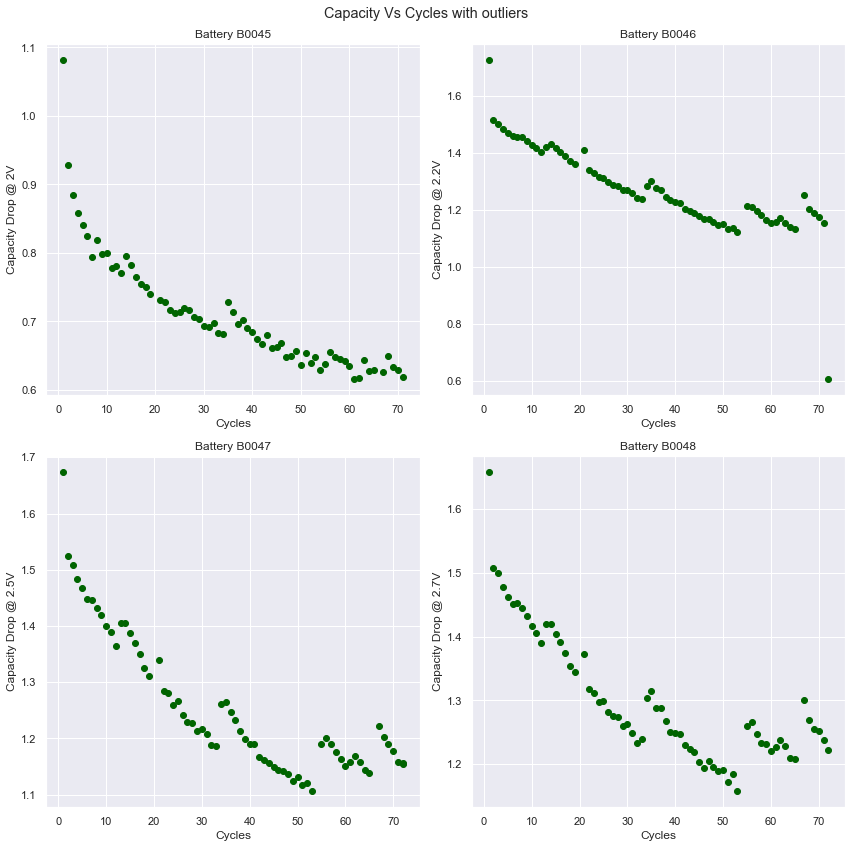

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Capacity Vs Cycles with outliers')

#Battery B0045 index start->0 end->69
axs[0,0].scatter(df['cycle'][:69],df['capacity'][:69],color='Darkgreen')
axs[0,0].set_title("Battery B0045")
axs[0,0].set_xlabel("Cycles")
axs[0,0].set_ylabel("Capacity Drop @ 2V")

#Battery B0046 index start->69 end->138
axs[0,1].scatter(df['cycle'][69:138],df['capacity'][69:138],color='Darkgreen')
axs[0,1].set_title("Battery B0046")
axs[0,1].set_xlabel("Cycles")
axs[0,1].set_ylabel("Capacity Drop @ 2.2V")

#Battery B0045 index start->138 end->208
axs[1,0].scatter(df['cycle'][138:208],df['capacity'][138:208],color='Darkgreen')
axs[1,0].set_title("Battery B0047")
axs[1,0].set_xlabel("Cycles")
axs[1,0].set_ylabel("Capacity Drop @ 2.5V")

#Battery B0045 index start->208 end->remaining
axs[1,1].scatter(df['cycle'][208:],df['capacity'][208:],color='Darkgreen')
axs[1,1].set_title("Battery B0048")
axs[1,1].set_xlabel("Cycles")
axs[1,1].set_ylabel("Capacity Drop @ 2.7V")
#axs[0,0].plot([0.,max(discharge["cycle"])], [1.15, 1.15],color="red")

plt.tight_layout()
plt.savefig('image/Visual/capacity_vs_cycle(with outliers).jpeg')
plt.show()

##### Replacing using ewm

In [10]:
outlier1=discharge['capacity'][:72].ewm(alpha=0.1).mean()
outlier2=discharge['capacity'][72:144].ewm(alpha=0.1).mean()
outlier3=discharge['capacity'][144:216].ewm(alpha=0.1).mean()
outlier4=discharge['capacity'][216:].ewm(alpha=0.1).mean()

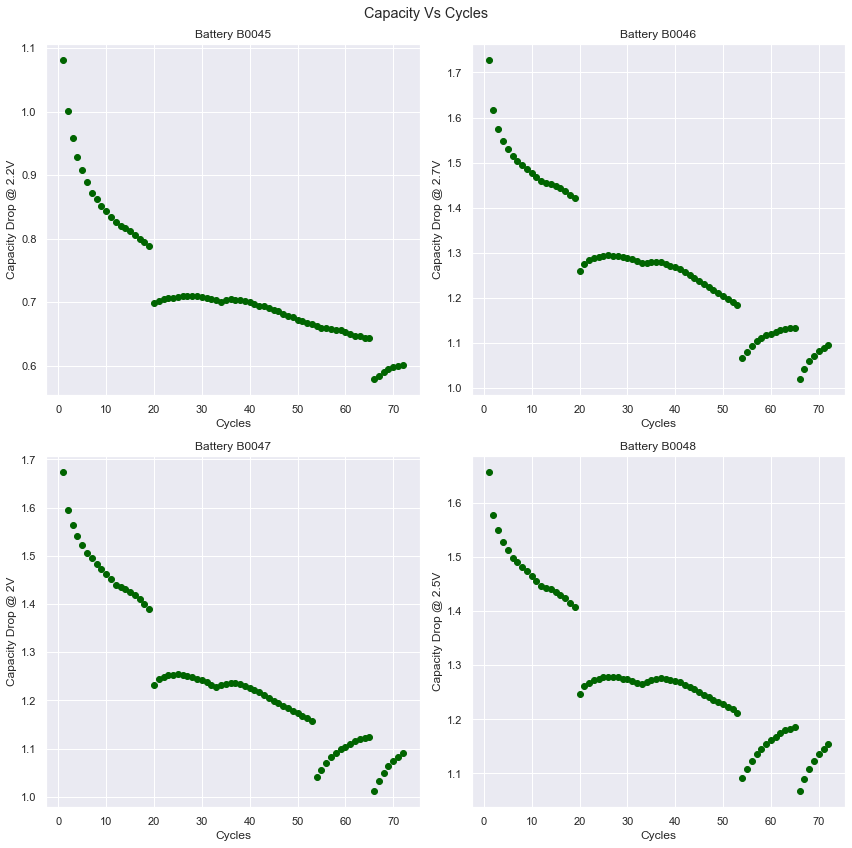

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Capacity Vs Cycles')

axs[0,0].scatter(discharge['cycle'][:72],outlier1,color='Darkgreen')
axs[0,0].set_title("Battery B0045")
axs[0,0].set_xlabel("Cycles")
axs[0,0].set_ylabel("Capacity Drop @ 2.2V")

axs[0,1].scatter(discharge['cycle'][72:144],outlier2,color='Darkgreen')
axs[0,1].set_title("Battery B0046")
axs[0,1].set_xlabel("Cycles")
axs[0,1].set_ylabel("Capacity Drop @ 2.7V")

axs[1,0].scatter(discharge['cycle'][144:216],outlier3,color='Darkgreen')
axs[1,0].set_title("Battery B0047")
axs[1,0].set_xlabel("Cycles")
axs[1,0].set_ylabel("Capacity Drop @ 2V")

axs[1,1].scatter(discharge['cycle'][216:],outlier4,color='Darkgreen')
axs[1,1].set_title("Battery B0048")
axs[1,1].set_xlabel("Cycles")
axs[1,1].set_ylabel("Capacity Drop @ 2.5V")
#axs[0,0].plot([0.,max(discharge["cycle"])], [1.15, 1.15],color="red")

plt.tight_layout()
plt.savefig('image/Visual/Cycles Vs Capacity.png')
plt.show()

    Above graph shows as capacity decrease with increase in number of battery cycles

#### cycles vs Maximum Voltage drop

In [12]:
discharge=df

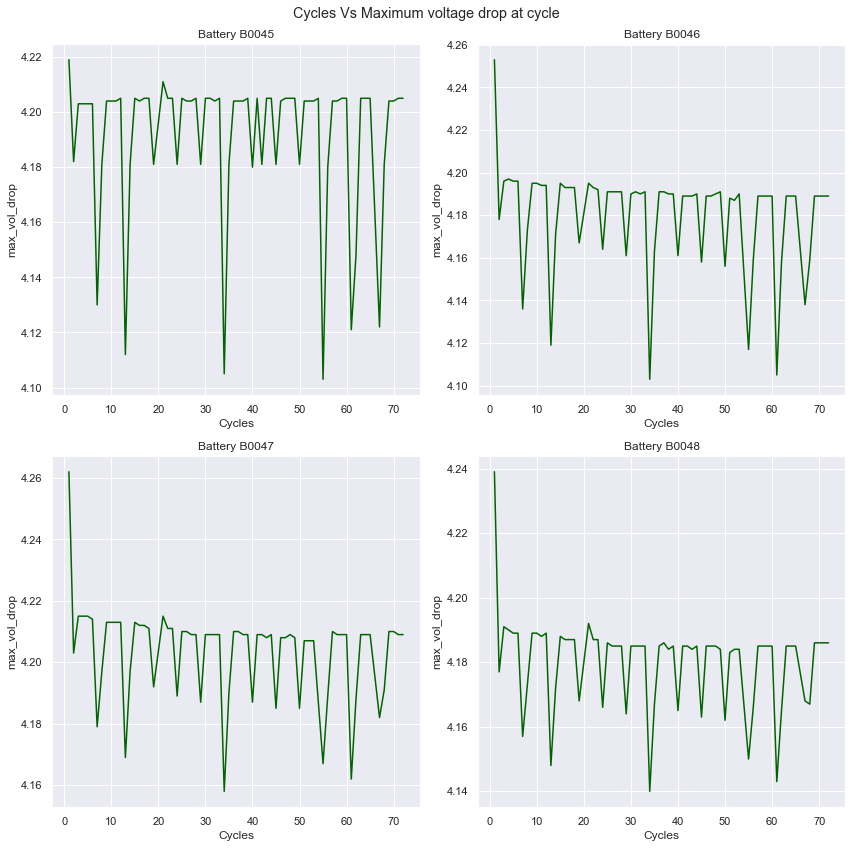

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Cycles Vs Maximum voltage drop at cycle')

axs[0,0].plot(discharge['cycle'][:70],discharge['max_voltage_drop'][:70],color='Darkgreen')
axs[0,0].set_title("Battery B0045")
axs[0,0].set_xlabel("Cycles")
axs[0,0].set_ylabel("max_vol_drop")

axs[0,1].plot(discharge['cycle'][70:139],discharge['max_voltage_drop'][70:139],color='Darkgreen')
axs[0,1].set_title("Battery B0046")
axs[0,1].set_xlabel("Cycles")
axs[0,1].set_ylabel("max_vol_drop")

axs[1,0].plot(discharge['cycle'][139:208],discharge['max_voltage_drop'][139:208],color='Darkgreen')
axs[1,0].set_title("Battery B0047")
axs[1,0].set_xlabel("Cycles")
axs[1,0].set_ylabel("max_vol_drop")

axs[1,1].plot(discharge['cycle'][208:],discharge['max_voltage_drop'][208:],color='Darkgreen')
axs[1,1].set_title("Battery B0048")
axs[1,1].set_xlabel("Cycles")
axs[1,1].set_ylabel("max_vol_drop")


plt.tight_layout()
plt.savefig('image/Visual/Cycles Vs Maximum voltage drop.png')
plt.show()

    from graph we can see how max_voltage difference in each cycles

#### Cycle vs DeltaV

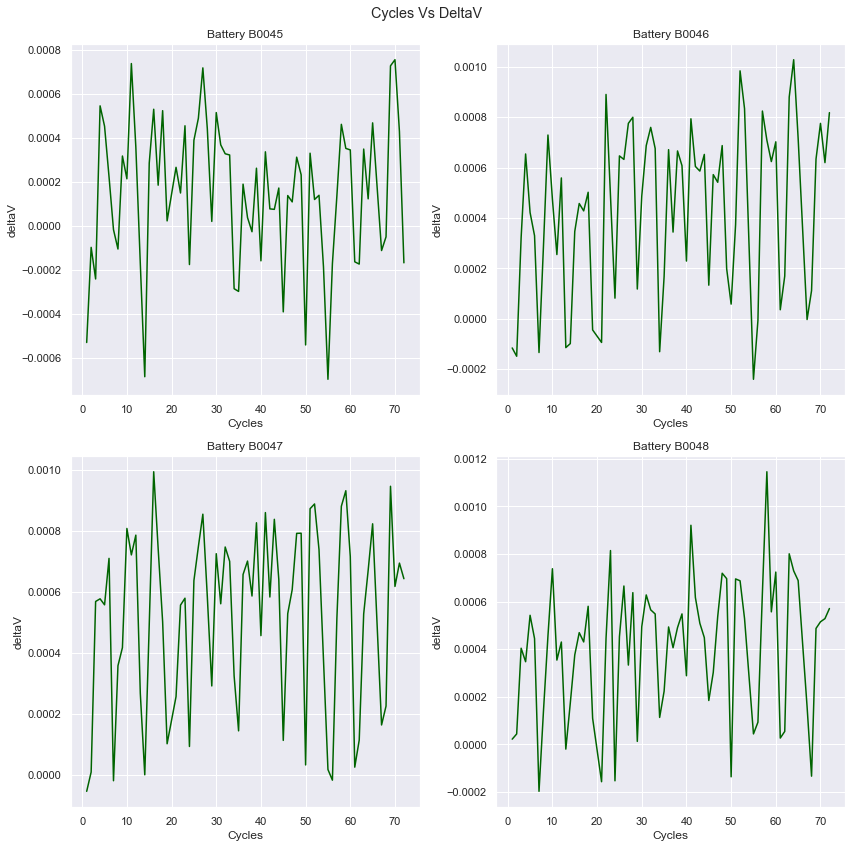

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Cycles Vs DeltaV')

axs[0,0].plot(discharge['cycle'][:70],discharge['deltaV'][:70],color='Darkgreen')
axs[0,0].set_title("Battery B0045")
axs[0,0].set_xlabel("Cycles")
axs[0,0].set_ylabel("deltaV")

axs[0,1].plot(discharge['cycle'][70:139],discharge['deltaV'][70:139],color='Darkgreen')
axs[0,1].set_title("Battery B0046")
axs[0,1].set_xlabel("Cycles")
axs[0,1].set_ylabel("deltaV")

axs[1,0].plot(discharge['cycle'][139:208],discharge['deltaV'][139:208],color='Darkgreen')
axs[1,0].set_title("Battery B0047")
axs[1,0].set_xlabel("Cycles")
axs[1,0].set_ylabel("deltaV")

axs[1,1].plot(discharge['cycle'][208:],discharge['deltaV'][208:],color='Darkgreen')
axs[1,1].set_title("Battery B0048")
axs[1,1].set_xlabel("Cycles")
axs[1,1].set_ylabel("deltaV")


plt.tight_layout()
plt.savefig('image/Visual/Cycles Vs DeltaV.jpeg')
plt.show()

    From the above graph we can see how deltaV plotted with respect to cycles

####  cycle vs Area under curve

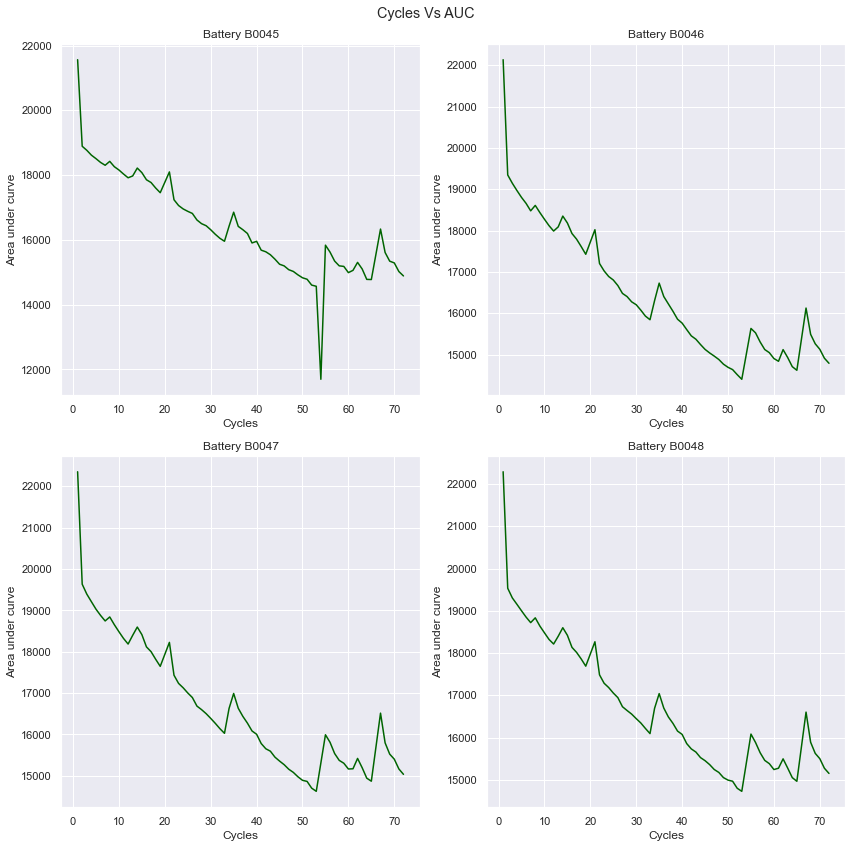

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Cycles Vs AUC')

axs[0,0].plot(discharge['cycle'][:70],discharge['auc'][:70],color='Darkgreen')
axs[0,0].set_title("Battery B0045")
axs[0,0].set_xlabel("Cycles")
axs[0,0].set_ylabel("Area under curve")

axs[0,1].plot(discharge['cycle'][70:139],discharge['auc'][70:139],color='Darkgreen')
axs[0,1].set_title("Battery B0046")
axs[0,1].set_xlabel("Cycles")
axs[0,1].set_ylabel("Area under curve")

axs[1,0].plot(discharge['cycle'][139:208],discharge['auc'][139:208],color='Darkgreen')
axs[1,0].set_title("Battery B0047")
axs[1,0].set_xlabel("Cycles")
axs[1,0].set_ylabel("Area under curve")

axs[1,1].plot(discharge['cycle'][208:],discharge['auc'][208:],color='Darkgreen')
axs[1,1].set_title("Battery B0048")
axs[1,1].set_xlabel("Cycles")
axs[1,1].set_ylabel("Area under curve")


plt.tight_layout()
plt.savefig('image/Visual/Cycles Vs AUC.png')
plt.show()

    From the above graph we can see how "Area under curve" plotted with respect to cycles

##### Cycles Vs Time_Taken

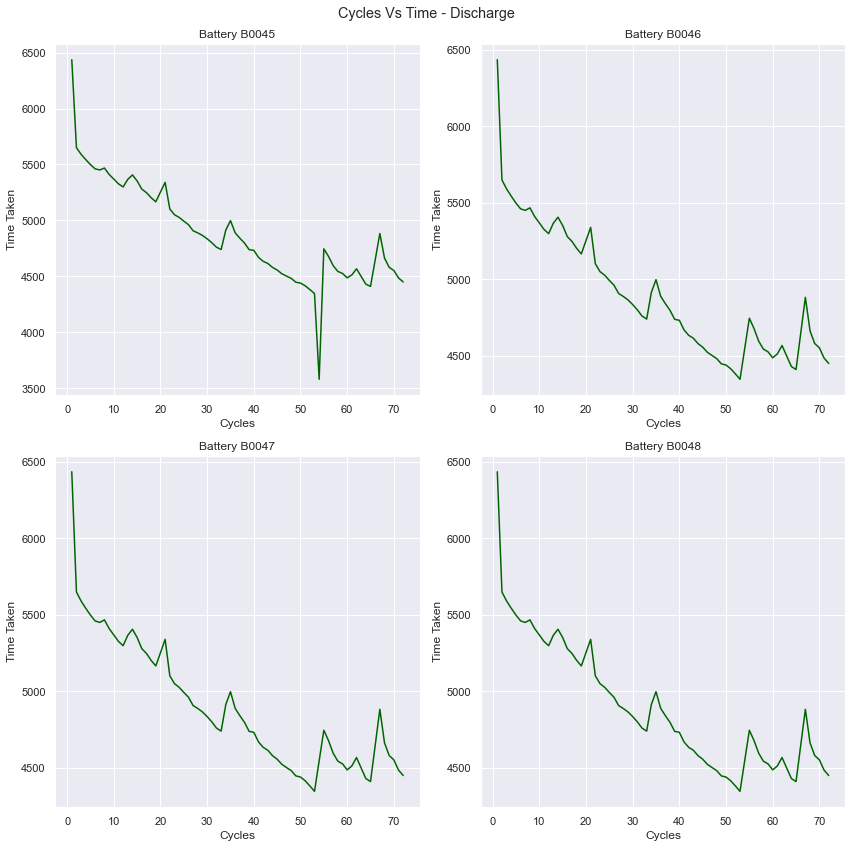

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Cycles Vs Time - Discharge')

axs[0,0].plot(discharge['cycle'][:70],discharge['time_taken'][:70],color='Darkgreen')
axs[0,0].set_title("Battery B0045")
axs[0,0].set_xlabel("Cycles")
axs[0,0].set_ylabel("Time Taken")

axs[0,1].plot(discharge['cycle'][70:139],discharge['time_taken'][70:139],color='Darkgreen')
axs[0,1].set_title("Battery B0046")
axs[0,1].set_xlabel("Cycles")
axs[0,1].set_ylabel("Time Taken")

axs[1,0].plot(discharge['cycle'][139:208],discharge['time_taken'][139:208],color='Darkgreen')
axs[1,0].set_title("Battery B0047")
axs[1,0].set_xlabel("Cycles")
axs[1,0].set_ylabel("Time Taken")

axs[1,1].plot(discharge['cycle'][208:],discharge['time_taken'][208:],color='Darkgreen')
axs[1,1].set_title("Battery B0048")
axs[1,1].set_xlabel("Cycles")
axs[1,1].set_ylabel("Time Taken")


plt.tight_layout()
plt.savefig('image/Visual/Cycles Vs Time-Discharge.png')
plt.show()

    From the above graph we can see that time taken for total discharge decrease with increase in cycles count

###### Discharge
    voltage - external force required to move the charges or electrons
    load voltage - voltage measured in the load
    battery voltage - voltage measured in the battery

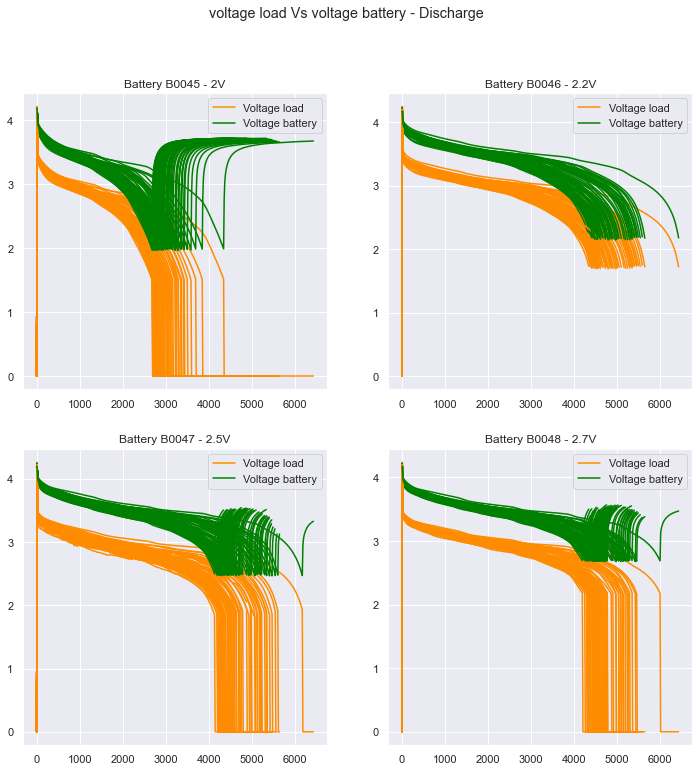

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('voltage load Vs voltage battery - Discharge')
for i in range(70):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[0,0].plot(discharge['time_sec'][i],discharge['voltage_load'][i],color='darkorange')
    axs[0,0].plot(discharge['time_sec'][i],discharge['voltage_battery'][i],color='green')
    axs[0,0].legend(labels=['Voltage load','Voltage battery'])
    axs[0,0].set_title("Battery B0045 - 2V")
for i in range(70,139):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[0,1].plot(discharge['time_sec'][i],discharge['voltage_load'][i],color='darkorange')
    axs[0,1].plot(discharge['time_sec'][i],discharge['voltage_battery'][i],color='green')
    axs[0,1].legend(labels=['Voltage load','Voltage battery'])
    axs[0,1].set_title("Battery B0046 - 2.2V")

for i in range(139,208):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[1,0].plot(discharge['time_sec'][i],discharge['voltage_load'][i],color='darkorange')
    axs[1,0].plot(discharge['time_sec'][i],discharge['voltage_battery'][i],color='green')
    axs[1,0].legend(labels=['Voltage load','Voltage battery'])
    axs[1,0].set_title("Battery B0047 - 2.5V")

for i in range(208,277):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[1,1].plot(discharge['time_sec'][i],discharge['voltage_load'][i],color='darkorange')
    axs[1,1].plot(discharge['time_sec'][i],discharge['voltage_battery'][i],color='green')
    axs[1,1].legend(labels=['Voltage load','Voltage battery'])
    axs[1,1].set_title("Battery B0048 - 2.7V")
plt.savefig('image/Visual/voltage load vs voltage battery - Discharge.png')


    From the graph we can see that time required for voltage to least value decreases with increase in cycles and also voltage measured at battery is higher than measured at load.

###### Discharge
    voltage - external force required to move the charges or electrons
    load voltage - voltage measured in the load
    battery voltage - voltage measured in the battery

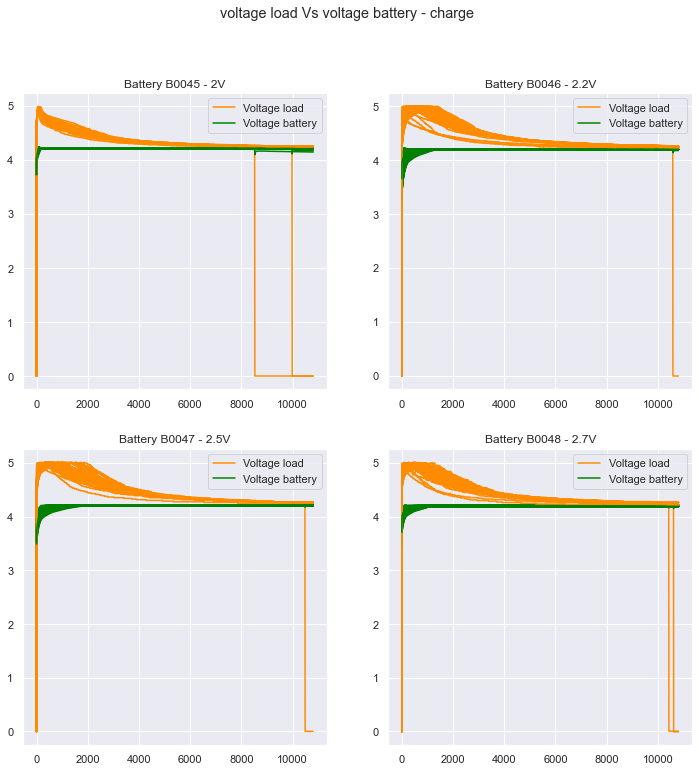

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('voltage load Vs voltage battery - charge')
for i in range(70):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[0,0].plot(charge['time_sec'][i],charge['voltage_load'][i],color='darkorange')
    axs[0,0].plot(charge['time_sec'][i],charge['voltage_battery'][i],color='green')
    axs[0,0].legend(labels=['Voltage load','Voltage battery'])
    axs[0,0].set_title("Battery B0045 - 2V")
for i in range(70,139):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[0,1].plot(charge['time_sec'][i],charge['voltage_load'][i],color='darkorange')
    axs[0,1].plot(charge['time_sec'][i],charge['voltage_battery'][i],color='green')
    axs[0,1].legend(labels=['Voltage load','Voltage battery'])
    axs[0,1].set_title("Battery B0046 - 2.2V")

for i in range(139,208):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[1,0].plot(charge['time_sec'][i],charge['voltage_load'][i],color='darkorange')
    axs[1,0].plot(charge['time_sec'][i],charge['voltage_battery'][i],color='green')
    axs[1,0].legend(labels=['Voltage load','Voltage battery'])
    axs[1,0].set_title("Battery B0047 - 2.5V")

for i in range(208,277):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[1,1].plot(charge['time_sec'][i],charge['voltage_load'][i],color='darkorange')
    axs[1,1].plot(charge['time_sec'][i],charge['voltage_battery'][i],color='green')
    axs[1,1].legend(labels=['Voltage load','Voltage battery'])
    axs[1,1].set_title("Battery B0048 - 2.7V")
plt.savefig('image/Visual/voltage load vs voltage battery - charge.png')



    From the above graph we can see that voltage of 4.2V is constantly maintained for charging

#### Current - flow of electric charge while discharge

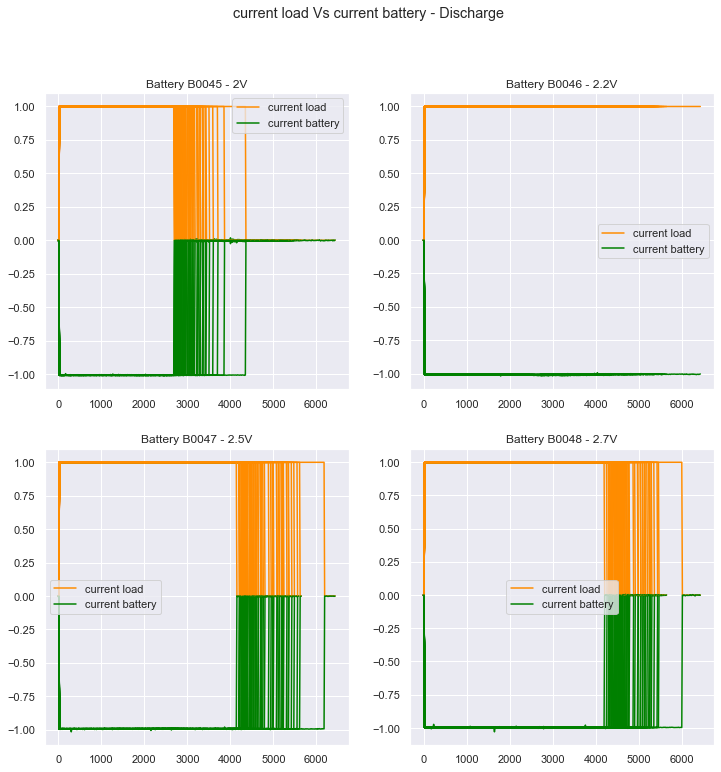

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('current load Vs current battery - Discharge')
for i in range(70):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[0,0].plot(discharge['time_sec'][i],discharge['current_load'][i],color='darkorange')
    axs[0,0].plot(discharge['time_sec'][i],discharge['current_battery'][i],color='green')
    axs[0,0].legend(labels=['current load','current battery'])
    axs[0,0].set_title("Battery B0045 - 2V")
for i in range(70,139):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[0,1].plot(discharge['time_sec'][i],discharge['current_load'][i],color='darkorange')
    axs[0,1].plot(discharge['time_sec'][i],discharge['current_battery'][i],color='green')
    axs[0,1].legend(labels=['current load','current battery'])
    axs[0,1].set_title("Battery B0046 - 2.2V")

for i in range(139,208):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[1,0].plot(discharge['time_sec'][i],discharge['current_load'][i],color='darkorange')
    axs[1,0].plot(discharge['time_sec'][i],discharge['current_battery'][i],color='green')
    axs[1,0].legend(labels=['current load','current battery'])
    axs[1,0].set_title("Battery B0047 - 2.5V")

for i in range(208,277):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[1,1].plot(discharge['time_sec'][i],discharge['current_load'][i],color='darkorange')
    axs[1,1].plot(discharge['time_sec'][i],discharge['current_battery'][i],color='green')
    axs[1,1].legend(labels=['current load','current battery'])
    axs[1,1].set_title("Battery B0048 - 2.7V")
plt.savefig('image/Visual/current load vs current battery - Discharge.png')

    From the plot we can say that our battery discharges contant of 1A for load which is shown in negative and our load also gets 1A current for contant period of time.
    As the cycle count increases the duration of contant current discharge decreases.

#### Current - flow of electric charge while discharge

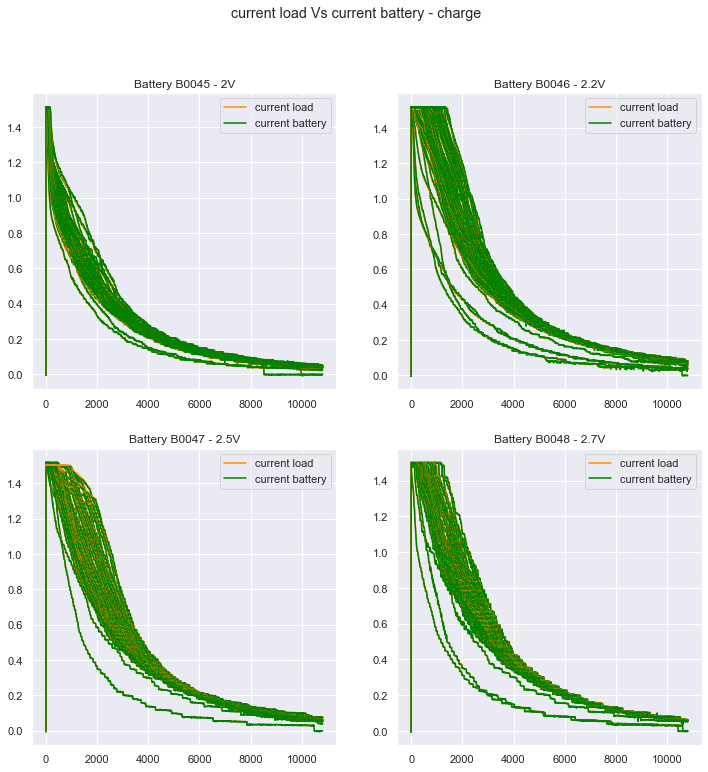

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('current load Vs current battery - charge')
for i in range(70):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[0,0].plot(charge['time_sec'][i],charge['current_load'][i],color='darkorange')
    axs[0,0].plot(charge['time_sec'][i],charge['current_battery'][i],color='green')
    axs[0,0].legend(labels=['current load','current battery'])
    axs[0,0].set_title("Battery B0045 - 2V")
for i in range(70,139):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[0,1].plot(charge['time_sec'][i],charge['current_load'][i],color='darkorange')
    axs[0,1].plot(charge['time_sec'][i],charge['current_battery'][i],color='green')
    axs[0,1].legend(labels=['current load','current battery'])
    axs[0,1].set_title("Battery B0046 - 2.2V")

for i in range(139,208):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[1,0].plot(charge['time_sec'][i],charge['current_load'][i],color='darkorange')
    axs[1,0].plot(charge['time_sec'][i],charge['current_battery'][i],color='green')
    axs[1,0].legend(labels=['current load','current battery'])
    axs[1,0].set_title("Battery B0047 - 2.5V")

for i in range(208,277):
    #plt.plot(discharge['time_sec'][i],discharge['voltage_battery'][i])
    axs[1,1].plot(charge['time_sec'][i],charge['current_load'][i],color='darkorange')
    axs[1,1].plot(charge['time_sec'][i],charge['current_battery'][i],color='green')
    axs[1,1].legend(labels=['current load','current battery'])
    axs[1,1].set_title("Battery B0048 - 2.7V")
plt.savefig('image/Visual/current load vs current battery - charge.png')

    From the graph we can see that current measured in both battery and charging wire is decrease with respect to time taken.

In [21]:
list_cols = {'voltage_load','temp_battery','time_sec','voltage_battery','current_load','current_battery'}
other_cols = list(set(discharge.columns) - set(list_cols))
exploded = [discharge[col].explode() for col in list_cols]
df2 = pd.DataFrame(dict(zip(list_cols, exploded)))
df2 = discharge[other_cols].merge(df2, how="right", left_index=True, right_index=True)
df2.drop(['date_time','amb_temp'],axis=1,inplace=True)
df2

,max_voltage_drop,deltaV,capacity,auc,time_taken,cycle,current_load,voltage_battery,current_battery,temp_battery,time_sec,voltage_load
0,4.219,-0.00053,1.081979,21562.16542,6436.141,1,0.0004,4.202937,-0.001855,6.546128,0.0,0.0
0,4.219,-0.00053,1.081979,21562.16542,6436.141,1,0.0004,4.203468,-0.001992,6.566539,9.36,4.219
0,4.219,-0.00053,1.081979,21562.16542,6436.141,1,0.998,3.957336,-1.007394,6.60526,23.281,3.487
0,4.219,-0.00053,1.081979,21562.16542,6436.141,1,0.998,3.933654,-1.005346,6.682724,36.406,3.455
0,4.219,-0.00053,1.081979,21562.16542,6436.141,1,0.998,3.915924,-1.005222,6.763142,49.625,3.429
...,...,...,...,...,...,...,...,...,...,...,...,...
96,4.205,0.000262,0.691181,15903.480349,4739.188,39,0.0004,3.71181,-0.000691,5.964492,4680.5,0.0
96,4.205,0.000262,0.691181,15903.480349,4739.188,39,0.0004,3.711769,-0.005092,5.97163,4695.172,0.0
96,4.205,0.000262,0.691181,15903.480349,4739.188,39,0.0004,3.712245,-0.000322,6.007273,4709.844,0.0
96,4.205,0.000262,0.691181,15903.480349,4739.188,39,0.0004,3.712192,-0.004352,6.037467,4724.532,0.0


In [22]:
list_cols = {'voltage_load','temp_battery','time_sec','voltage_battery','current_load','current_battery'} #list of columns to explode
other_cols = list(set(charge.columns) - set(list_cols))
exploded = [charge[col].explode() for col in list_cols]
df1 = pd.DataFrame(dict(zip(list_cols, exploded)))
df1 = charge[other_cols].merge(df1, how="right", left_index=True, right_index=True)

In [23]:
df2.info() #Getting information about data like datatype

<class 'pandas.core.frame.DataFrame'>
Index: 96117 entries, 0 to 96
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   max_voltage_drop  96117 non-null  object
 1   deltaV            96117 non-null  object
 2   capacity          96117 non-null  object
 3   auc               96117 non-null  object
 4   time_taken        96117 non-null  object
 5   cycle             96117 non-null  int64 
 6   current_load      96117 non-null  object
 7   voltage_battery   96117 non-null  object
 8   current_battery   96117 non-null  object
 9   temp_battery      96117 non-null  object
 10  time_sec          96117 non-null  object
 11  voltage_load      96117 non-null  object
dtypes: int64(1), object(11)
memory usage: 9.5+ MB


In [24]:
df1.drop(['date_time'],axis=1,inplace=True) # Dropping date_time because it is string object which can't be converted into float object
df1=df1.astype(float) #Changing all DT into float
#df1.sort_values('cycle') # sorting DF with respect to cycle
df1.info()


<class 'pandas.core.frame.DataFrame'>
Index: 403860 entries, 101 to 98
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   amb_temp         403860 non-null  float64
 1   time_taken       403860 non-null  float64
 2   current_load     403860 non-null  float64
 3   voltage_battery  403860 non-null  float64
 4   current_battery  403860 non-null  float64
 5   temp_battery     403860 non-null  float64
 6   time_sec         403860 non-null  float64
 7   voltage_load     403860 non-null  float64
dtypes: float64(8)
memory usage: 27.7+ MB


In [25]:
df1.describe()

,amb_temp,time_taken,current_load,voltage_battery,current_battery,temp_battery,time_sec,voltage_load
count,403860.0,403860.000000,403860.000000,403860.000000,403860.000000,403860.000000,403860.000000,403860.000000
mean,4.0,10805.755800,0.395274,4.194874,0.395568,6.367250,5386.307996,4.409186
std,0.0,2.272328,0.408449,0.040802,0.408518,1.128381,3130.445049,0.287342
min,4.0,10802.015000,-0.002000,3.033504,-0.009247,3.312791,0.000000,-0.010000
25%,4.0,10804.078000,0.106000,4.190668,0.105406,5.623525,2672.671000,4.271000
50%,4.0,10805.125000,0.214000,4.200571,0.215597,6.189312,5384.219000,4.326000
75%,4.0,10807.812000,0.530000,4.206749,0.531600,6.900151,8097.422000,4.491000
max,4.0,10810.344000,1.507000,4.234121,1.521341,14.561398,10810.344000,5.011000


#### Heatmap

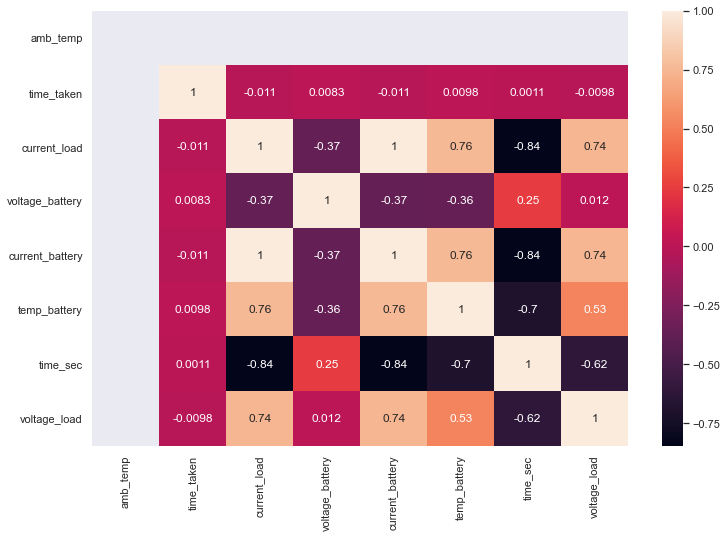

In [26]:
plt.figure(figsize=(12,8))
sns.heatmap(df1.corr(),annot=True)
plt.savefig('image/Heatmap/Charge Heatmap.png')
plt.show()

In [27]:
df2=df2.apply(pd.to_numeric) # Change data type into float for future evaluvation

In [28]:
df2.info() #chcking datatype

<class 'pandas.core.frame.DataFrame'>
Index: 96117 entries, 0 to 96
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   max_voltage_drop  96117 non-null  float64
 1   deltaV            96117 non-null  float64
 2   capacity          96117 non-null  float64
 3   auc               96117 non-null  float64
 4   time_taken        96117 non-null  float64
 5   cycle             96117 non-null  int64  
 6   current_load      96117 non-null  float64
 7   voltage_battery   96117 non-null  float64
 8   current_battery   96117 non-null  float64
 9   temp_battery      96117 non-null  float64
 10  time_sec          96117 non-null  float64
 11  voltage_load      96117 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 9.5+ MB


In [29]:
df2.describe()

,max_voltage_drop,deltaV,capacity,auc,time_taken,cycle,current_load,voltage_battery,current_battery,temp_battery,time_sec,voltage_load
count,96117.000000,96117.000000,96117.000000,96117.000000,96117.000000,96117.000000,96117.000000,96117.000000,96117.000000,96117.000000,96117.000000,96117.000000
mean,4.189562,0.000368,1.148636,16743.748684,4945.382331,33.690169,0.877481,3.385867,-0.879044,8.736354,2462.792475,2.504930
std,0.022931,0.000340,0.274730,1608.012208,436.444099,20.876307,0.326505,0.337776,0.326865,2.009876,1452.736815,0.975904
min,4.103000,-0.000698,0.606948,11693.664166,3581.188000,1.000000,0.000200,1.964052,-1.029288,3.635807,0.000000,0.000000
25%,4.184000,0.000113,1.081979,15373.477798,4568.438000,15.000000,0.998000,3.228118,-1.005650,7.391324,1215.218000,2.501000
50%,4.190000,0.000430,1.218668,16415.040606,4866.250000,33.000000,0.998800,3.444340,-0.997174,8.359896,2440.515000,2.849000
75%,4.205000,0.000637,1.329152,18097.010804,5327.406000,51.000000,0.999000,3.627222,-0.994894,9.760559,3674.313000,3.047000
max,4.262000,0.001145,1.728239,22350.422970,6436.141000,72.000000,1.000200,4.246764,0.018424,16.878888,6436.141000,4.262000


In [30]:
df2.drop(['cycle','capacity'],axis=1).corr() #Checking correaltion of features

,max_voltage_drop,deltaV,auc,time_taken,current_load,voltage_battery,current_battery,temp_battery,time_sec,voltage_load
max_voltage_drop,1.000000,0.429096,0.195060,0.171226,-0.035027,0.033508,0.038295,-0.013787,0.025563,-0.036749
deltaV,0.429096,1.000000,-0.246379,-0.278030,0.176088,0.010489,-0.172620,-0.058287,-0.041636,0.180244
auc,0.195060,-0.246379,1.000000,0.995498,0.025156,0.078646,-0.024212,-0.095383,0.149110,0.052968
time_taken,0.171226,-0.278030,0.995498,1.000000,0.008939,0.070434,-0.009159,-0.073619,0.149783,0.035272
current_load,-0.035027,0.176088,0.025156,0.008939,1.000000,-0.258969,-0.999849,0.042340,-0.378869,0.917694
voltage_battery,0.033508,0.010489,0.078646,0.070434,-0.258969,1.000000,0.260969,-0.842870,-0.567875,0.086455
current_battery,0.038295,-0.172620,-0.024212,-0.009159,-0.999849,0.260969,1.000000,-0.046447,0.380502,-0.917541
temp_battery,-0.013787,-0.058287,-0.095383,-0.073619,0.042340,-0.842870,-0.046447,1.000000,0.480959,-0.235544
time_sec,0.025563,-0.041636,0.149110,0.149783,-0.378869,-0.567875,0.380502,0.480959,1.000000,-0.606284
voltage_load,-0.036749,0.180244,0.052968,0.035272,0.917694,0.086455,-0.917541,-0.235544,-0.606284,1.000000


## Heatmap for Correlation

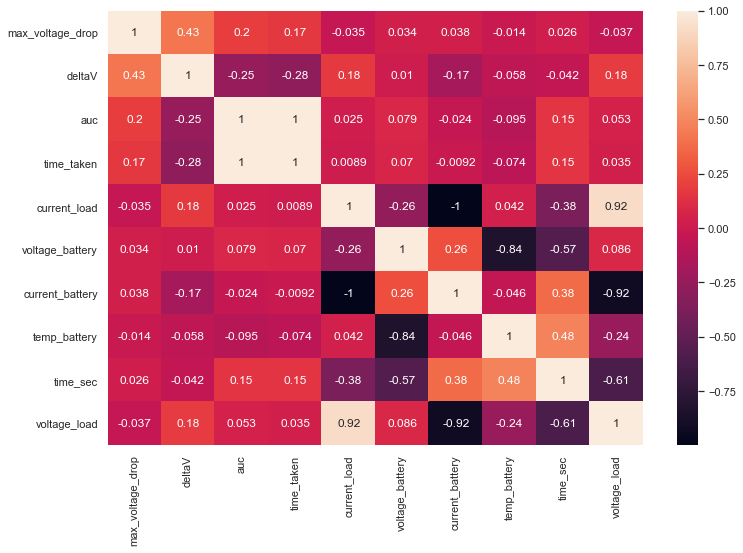

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(df2.drop(['cycle','capacity'],axis=1).corr(),annot=True)
plt.savefig('image/Heatmap/Discharge Heatman.png')
plt.show()

Function to get high correlated columns

## Features 

In [32]:
df = pd.read_csv('Dataset.csv')

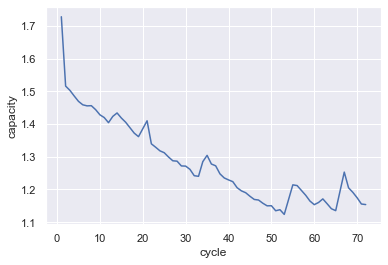

In [33]:
plt.plot(df['cycle'],df['capacity'])
plt.xlabel('cycle')
plt.ylabel('capacity')
plt.savefig('image/Features/Cycle vs Capacity.png')

The discharge capacity of the battery cells cycled at different cycling number shows that the battery’s performances become worse with the increasing of cycling number.

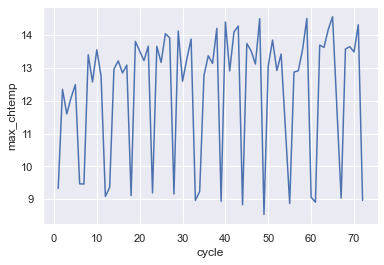

In [34]:
plt.plot(df['cycle'],df['max_chtemp'])
plt.xlabel('cycle')
plt.ylabel('max_chtemp')
plt.savefig('image/Features/Cycle vs max_chtemp.png')

From the above plot shows that the maximum charge temperature is independent to cycle because the fluctuation occurs from cycle to cycle.

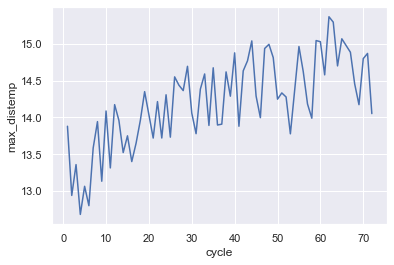

In [35]:
plt.plot(df['cycle'],df['max_distemp'])
plt.xlabel('cycle')
plt.ylabel('max_distemp')
plt.savefig('image/Features/Cycle vs max_distemp.png')

The diagram clearly said that the temperature is unrelated to cycle because of irregularity of the plot of cycle vs max_distemp.

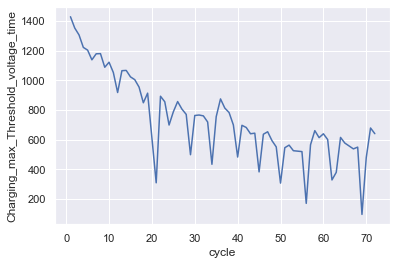

In [36]:
plt.plot(df['cycle'],df['Charging_max_Threshold_voltage_time'])
plt.xlabel('cycle')
plt.ylabel('Charging_max_Threshold_voltage_time')
plt.savefig('image/Features/Cycle vs Charging_max_Threshold_voltage_time.png')

This picture shows the gradual decrease in maximum threshold voltage time of charging with respective cycle.So cycle depends on maximum threshold voltage

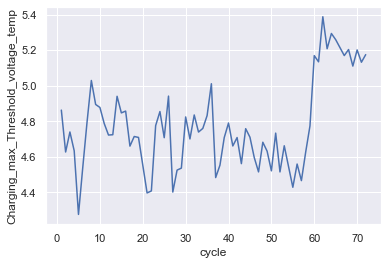

In [37]:
plt.plot(df['cycle'],df['Charging_max_Threshold_voltage_temp'])
plt.xlabel('cycle')
plt.ylabel('Charging_max_Threshold_voltage_temp')
plt.savefig('image/Features/Cycle vs Charging_max_Threshold_voltage_temp.png')

From above visual it says that due to varying temperature of maximum threshold voltage for each cycle,temperature of threshold voltage may not be the important feature with respect to cycle

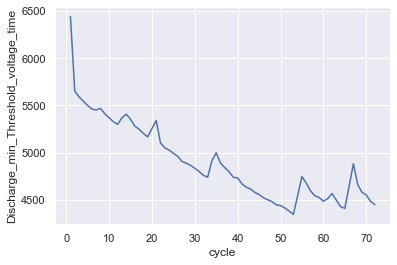

In [38]:
plt.plot(df['cycle'],df['Discharge_min_Threshold_voltage_time'])
plt.xlabel('cycle')
plt.ylabel('Discharge_min_Threshold_voltage_time')
plt.savefig('image/Features/Cycle vs Discharge_min_Threshold_voltage_time.png')

The diagram shows the continuous reduction in minimum threshold voltage time of discharging with respective cycle.So cycle depends on minimum threshold voltage too.

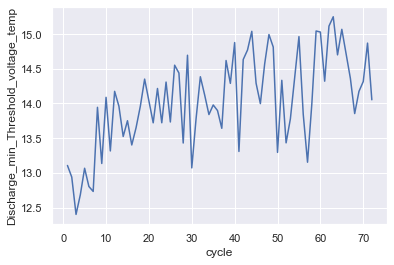

In [39]:
plt.plot(df['cycle'],df['Discharge_min_Threshold_voltage_temp'])
plt.xlabel('cycle')
plt.ylabel('Discharge_min_Threshold_voltage_temp')
plt.savefig('image/Features/Cycle vs Discharge_min_Threshold_voltage_temp.png')

From above visual it says that due to varying temperature of minimum threshold voltage for every cycle,temperature of threshold voltage may not be the key feature with respect to cycle

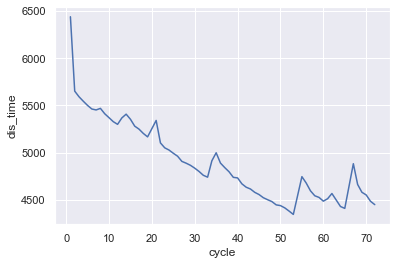

In [40]:
plt.plot(df['cycle'],df['dis_time'])
plt.xlabel('cycle')
plt.ylabel('dis_time')
plt.savefig('image/Features/Cycle vs Discharge Time.png')

From the above plot if cycle increases,the discharge time decreases.So it says that the discharge time is dependent on cycle and viseversa.

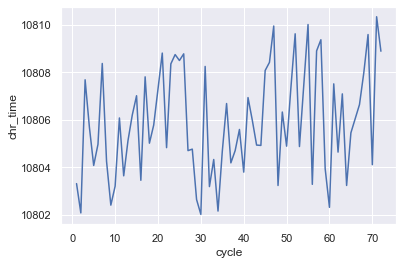

In [41]:
plt.plot(df['cycle'],df['chr_time'])
plt.xlabel('cycle')
plt.ylabel('chr_time')
plt.savefig('image/Features/Cycle vs Charge_Time.png')

Here its clear that,there is no relationship between cycle and charging time for this data because of irregularity.

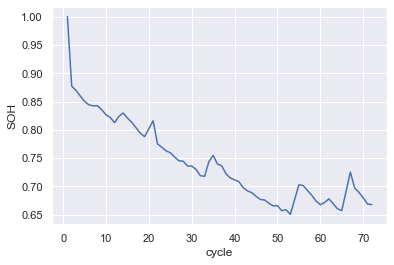

In [42]:
plt.plot(df['cycle'],df['SOH'])
plt.xlabel('cycle')
plt.ylabel('SOH')
plt.savefig('image/Features/Cycle vs SOH.png')

SOH is the capacity in terms of percentage.So the SOH is become less when cycle goes higher.

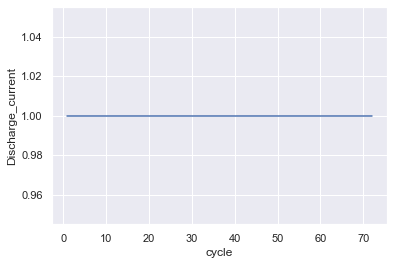

In [43]:
plt.plot(df['cycle'],df['Discharge_current'])
plt.xlabel('cycle')
plt.ylabel('Discharge_current')
plt.savefig('image/Features/Cycle vs Discharge_current.png')

The discharge current is 1 Amps for all the cycle.It does not cause any change with or without discharge current in model because it is a constant.

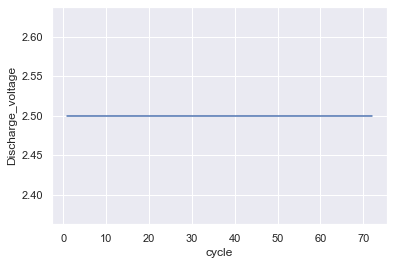

In [44]:
plt.plot(df['cycle'],df['Discharge_voltage'])
plt.xlabel('cycle')
plt.ylabel('Discharge_voltage')
plt.savefig('image/Features/Cycle vs Discharge_voltage.png')

The discharge voltage is 2.5 V for all the cycle.It does not cause any change with or without discharge current in model because it is a constant.

# END